In [1]:
import json
import yaml
import random
import numpy as np
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
N = 10   # number of random queries to display
SEED = 100

# Project root (one level above notebooks/)
ROOT = Path(__vsc_ipynb_file__).resolve().parent.parent if "__vsc_ipynb_file__" in dir() else Path.cwd().parent
ARTIFACTS = ROOT / "artifacts"

# Load dataset config
with open(ROOT / "configs" / "datasets.yaml") as f:
    cfg = yaml.safe_load(f)

ref_name = cfg["reference"]["name"]
candidates = list(cfg["candidates"].keys())

def pretty(name):
    """Human-friendly dataset label."""
    return name.replace("_", "-")

rng = random.Random(SEED)

In [ ]:
# ── Helpers ────────────────────────────────────────────────────────────────
def load_paths(jsonl_path):
    """Load image paths from `paths.jsonl`."""
    jsonl_path = Path(jsonl_path)
    if not jsonl_path.is_file():
        raise FileNotFoundError(f"Missing paths jsonl: {jsonl_path}")
    paths = []
    with jsonl_path.open("r") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            obj = json.loads(line)
            p = obj.get("path") or obj.get("rel_path")
            if p is not None:
                paths.append(p)
    return paths


def load_image(path, max_edge=512):
    """Load and thumbnail an image for visualization."""
    with Image.open(path) as im:
        img = im.convert("RGB")
    w, h = img.size
    scale = max_edge / max(w, h)
    if scale < 1:
        img = img.resize((int(w * scale), int(h * scale)), Image.BICUBIC)
    return img

In [4]:
# ── Load retrieval data ────────────────────────────────────────────────────
ref_paths = load_paths(ARTIFACTS / "embeddings" / ref_name / "paths.jsonl")
M = len(ref_paths)
sample_idx = rng.sample(range(M), N)

dataset_data = {}
for cand in candidates:
    retr_dir = ARTIFACTS / "retrieval" / f"{ref_name}_{cand}"
    dataset_data[cand] = {
        "paths": load_paths(ARTIFACTS / "embeddings" / cand / "paths.jsonl"),
        "nn_idx": np.load(retr_dir / "nn_idx.npy"),
        "nn_sim": np.load(retr_dir / "nn_sim.npy"),
    }

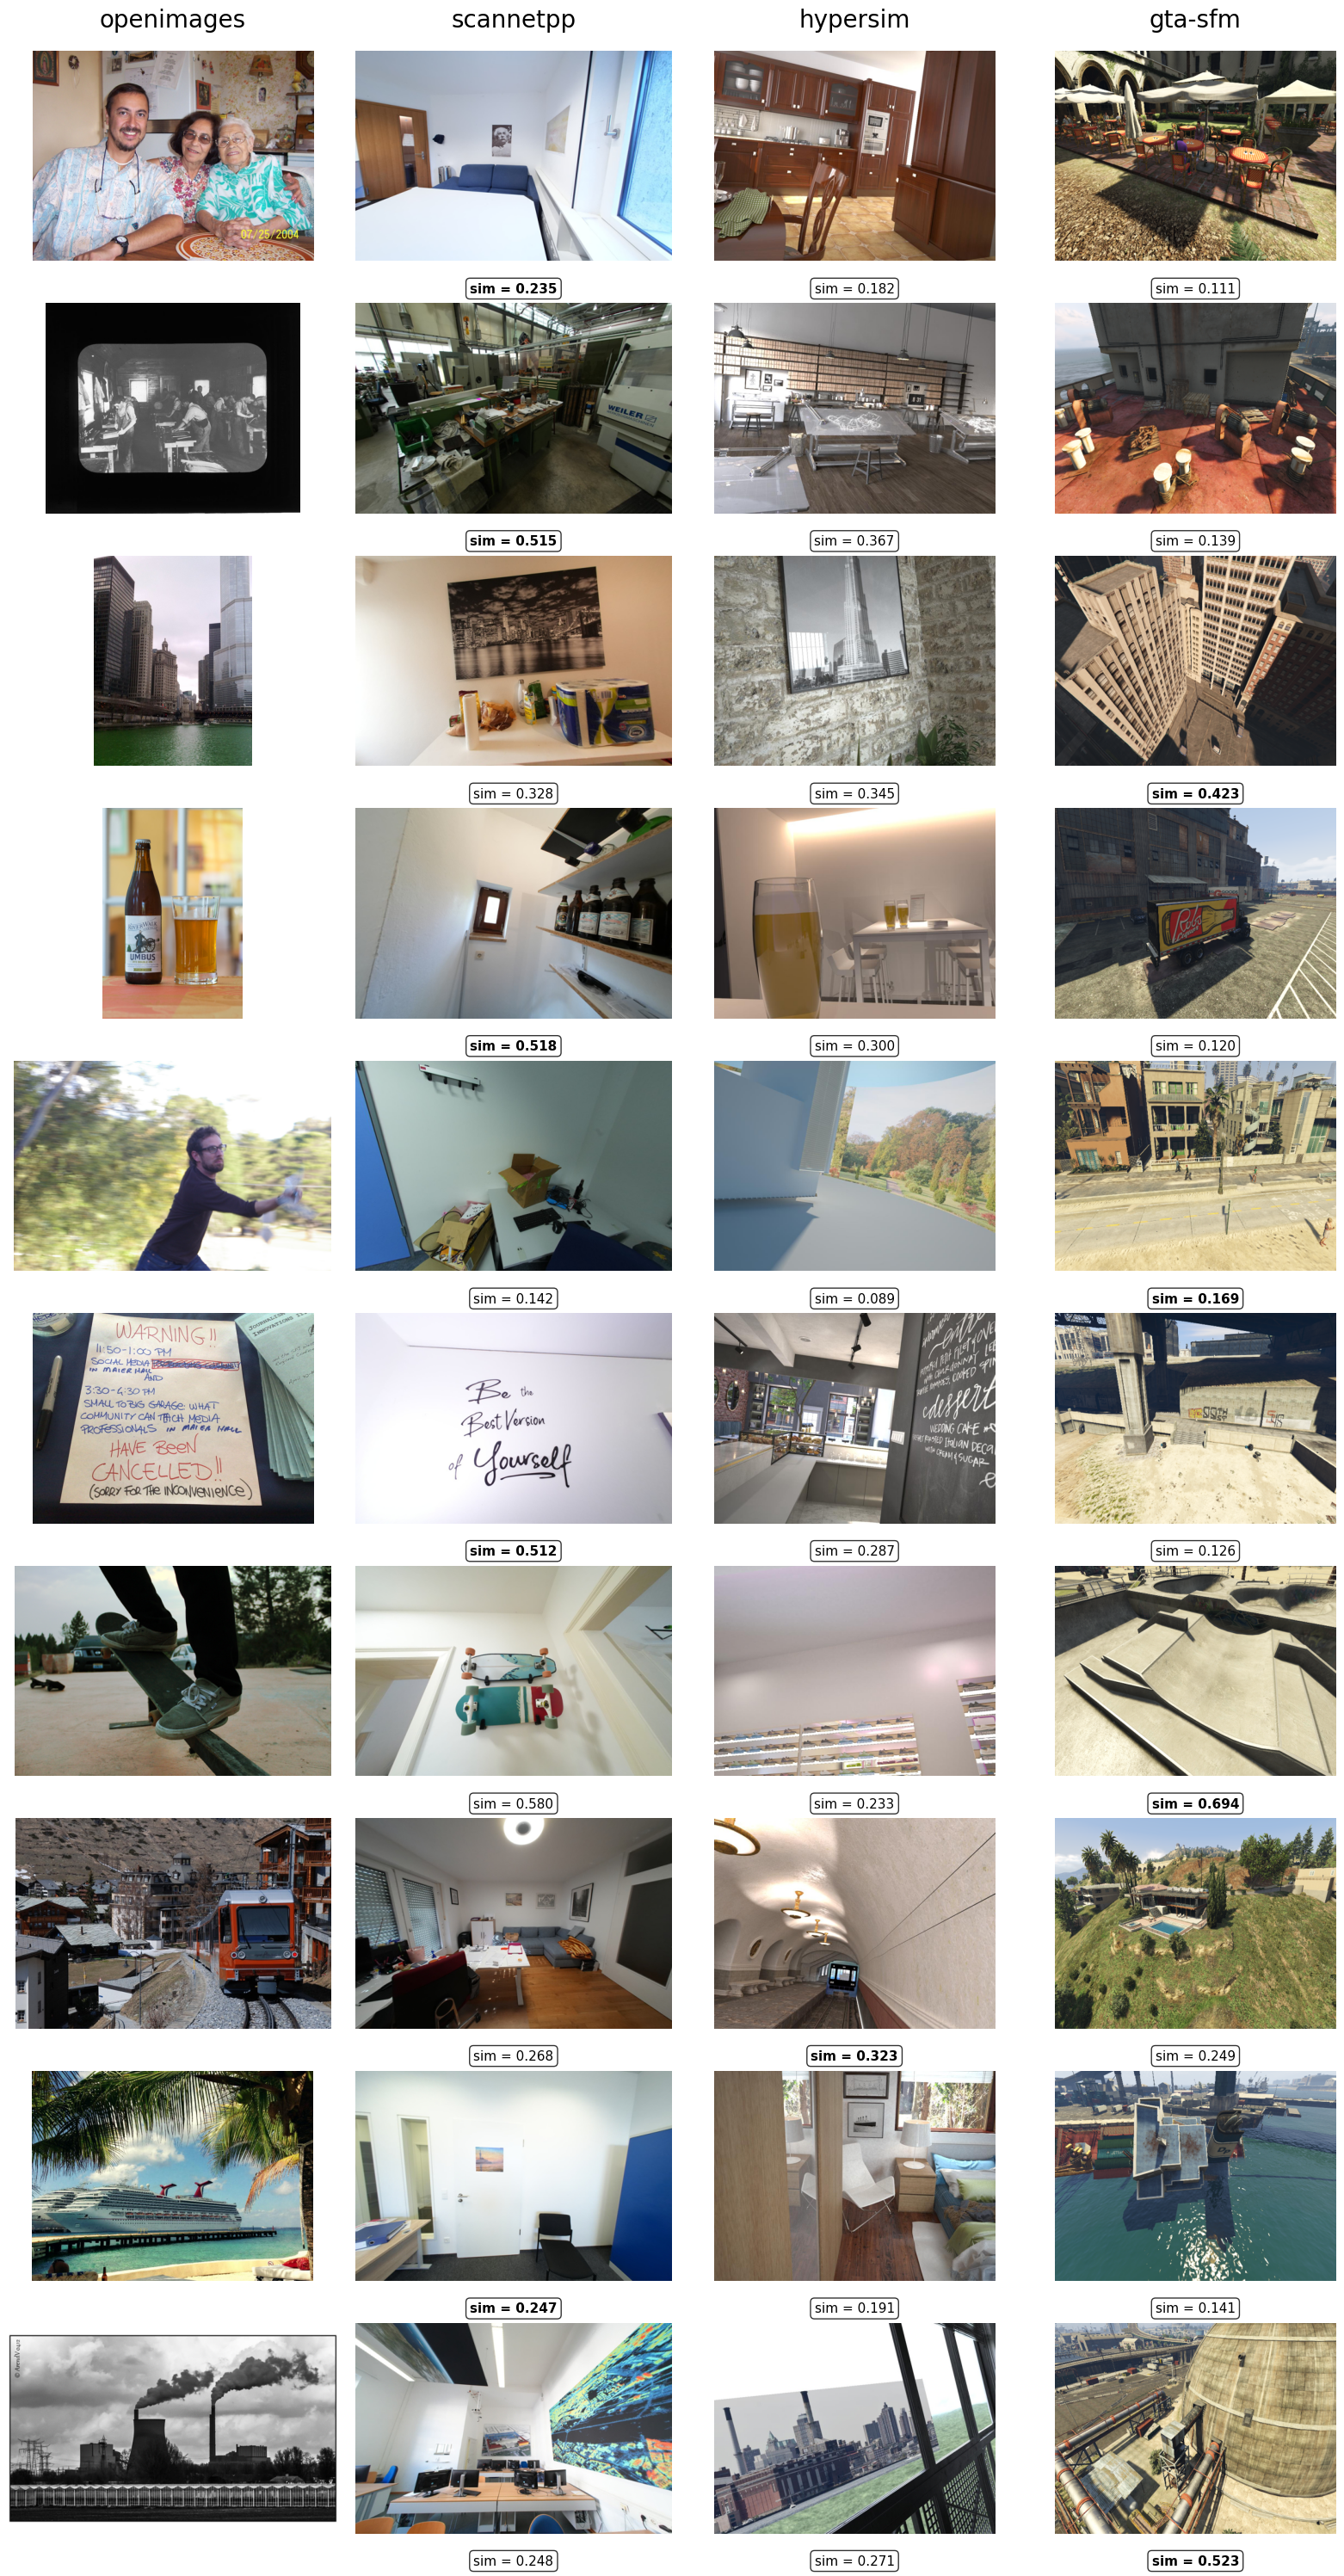

In [5]:
# ── 1-NN retrieval grid ────────────────────────────────────────────────────
n_cols = 1 + len(candidates)
fig, axes = plt.subplots(N, n_cols, figsize=(4 * n_cols, 3 * N))

# Column titles
col_titles = [pretty(ref_name)] + [pretty(c) for c in candidates]
for j, title in enumerate(col_titles):
    axes[0, j].set_title(title, fontsize=20, pad=20)

for row, qi in enumerate(sample_idx):
    # Reference image
    axes[row, 0].imshow(load_image(ref_paths[qi]))
    axes[row, 0].axis("off")

    # Similarity scores for bolding the best match
    sims = {c: float(dataset_data[c]["nn_sim"][qi]) for c in candidates}
    best = max(sims, key=sims.get)

    # Candidate columns
    for col, cand in enumerate(candidates, start=1):
        data = dataset_data[cand]
        idx = data["nn_idx"][qi]
        sim = sims[cand]

        axes[row, col].imshow(load_image(data["paths"][idx]))
        axes[row, col].axis("off")
        axes[row, col].text(
            0.5, -0.1, f"sim = {sim:.3f}",
            transform=axes[row, col].transAxes,
            ha="center", va="top",
            fontweight="bold" if cand == best else "normal",
            fontsize=11,
            bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8),
        )

plt.tight_layout()
plt.subplots_adjust(hspace=0.2)
plt.show()